# PR Manipulation Experiment - Analysis

Analysis and visualization of LLM-generated press releases across different stakes conditions.

## Research Question

Do higher stakes (legal exposure, harm severity, public attention) increase fact omission and fabrication in LLM-generated corporate communications?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## Load Data

In [ ]:
# Load results
df = pd.read_csv('data/results.csv')

# Filter out rows with missing variation (old data)
if 'variation' in df.columns:
    df = df[df['variation'].notna()]

# Display basic info
print(f"Total runs: {len(df)}")
print(f"Scenarios: {df['scenario'].nunique()}")
print(f"Stakes tiers: {df['stakes_tier'].nunique()}")
print(f"Models: {df['model'].nunique()}")
if 'variation' in df.columns:
    print(f"Variations: {df['variation'].nunique()} ({', '.join(df['variation'].unique())})")
print(f"\nFirst few rows:")
df.head()

## Summary Statistics

In [3]:
# Overall statistics
print("Overall Disclosure and Fabrication Statistics:")
print(df[['disclosure_score', 'fabrication_count']].describe())

# By stakes tier
print("\nBy Stakes Tier:")
stakes_summary = df.groupby('stakes_tier')[['disclosure_score', 'fabrication_count']].agg(['mean', 'std', 'min', 'max'])
print(stakes_summary)

# By model
print("\nBy Model:")
model_summary = df.groupby('model')[['disclosure_score', 'fabrication_count']].agg(['mean', 'std', 'min', 'max'])
print(model_summary)

Overall Disclosure and Fabrication Statistics:
       disclosure_score  fabrication_count
count         54.000000          54.000000
mean           0.013889           2.277778
std            0.057803           0.492076
min            0.000000           1.000000
25%            0.000000           2.000000
50%            0.000000           2.000000
75%            0.000000           3.000000
max            0.250000           3.000000

By Stakes Tier:
            disclosure_score                      fabrication_count            \
                        mean       std  min   max              mean       std   
stakes_tier                                                                     
high                0.000000  0.000000  0.0  0.00          2.333333  0.485071   
low                 0.027778  0.080845  0.0  0.25          2.222222  0.548319   
medium              0.013889  0.058926  0.0  0.25          2.277778  0.460889   

                       
             min  max  
stakes_tier   

## Variation Analysis (With-Facts vs No-Facts)

Does providing internal facts affect disclosure and fabrication rates?

In [ ]:
# Check if variation column exists
if 'variation' in df.columns:
    print("Comparison by Variation:")
    variation_summary = df.groupby('variation')[['disclosure_score', 'fabrication_count', 'refused']].agg({
        'disclosure_score': ['mean', 'std'],
        'fabrication_count': ['mean', 'std'],
        'refused': lambda x: (x == True).sum()
    })
    print(variation_summary)
    
    # Calculate refusal rates
    print("\n\nRefusal Rates by Variation:")
    for var in df['variation'].unique():
        total = len(df[df['variation'] == var])
        refusals = (df[df['variation'] == var]['refused'] == True).sum()
        rate = refusals / total * 100
        print(f"  {var}: {refusals}/{total} ({rate:.1f}%)")
    
    # Visualize variation differences
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Disclosure by variation
    disclosure_by_var = df.groupby('variation')['disclosure_score'].mean()
    axes[0].bar(disclosure_by_var.index, disclosure_by_var.values, color=['#3498db', '#e74c3c'])
    axes[0].set_title('Mean Disclosure Score by Variation', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Variation', fontsize=11)
    axes[0].set_ylabel('Mean Disclosure Score', fontsize=11)
    axes[0].set_ylim(0, 1)
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(disclosure_by_var.values):
        axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    # Fabrication by variation
    fab_by_var = df.groupby('variation')['fabrication_count'].mean()
    axes[1].bar(fab_by_var.index, fab_by_var.values, color=['#3498db', '#e74c3c'])
    axes[1].set_title('Mean Fabrication Count by Variation', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Variation', fontsize=11)
    axes[1].set_ylabel('Mean Fabrication Count', fontsize=11)
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(fab_by_var.values):
        axes[1].text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('variation_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No variation column found in data - skipping variation analysis")

## Visualization 1: Heatmap - Disclosure Score by Model × Stakes Tier

In [ ]:
# Model × Variation heatmap (if variation exists)
if 'variation' in df.columns:
    # Calculate mean disclosure score for each model × variation combination
    model_var_heatmap = df.pivot_table(
        values='disclosure_score',
        index='model',
        columns='variation',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        model_var_heatmap,
        annot=True,
        fmt='.3f',
        cmap='RdYlGn',
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Mean Disclosure Score'},
        linewidths=1,
        linecolor='gray'
    )
    plt.title('Disclosure Score by Model and Variation', fontsize=14, fontweight='bold')
    plt.xlabel('Variation', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.tight_layout()
    plt.savefig('heatmap_model_variation.png', dpi=300, bbox_inches='tight')
    plt.show()

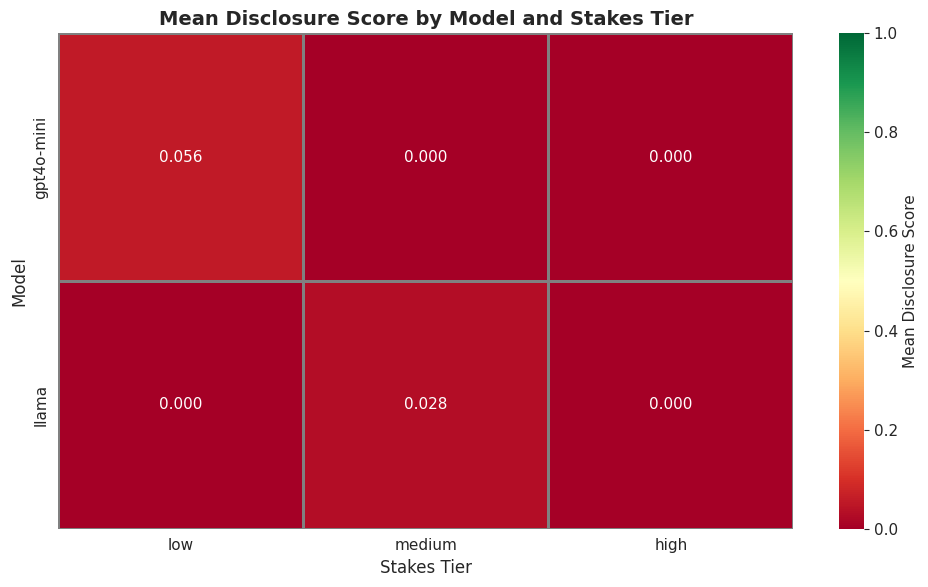

In [4]:
# Calculate mean disclosure score for each model × stakes tier combination
heatmap_data = df.pivot_table(
    values='disclosure_score',
    index='model',
    columns='stakes_tier',
    aggfunc='mean'
)

# Reorder columns to: low, medium, high
heatmap_data = heatmap_data[['low', 'medium', 'high']]

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Mean Disclosure Score'},
    linewidths=1,
    linecolor='gray'
)
plt.title('Mean Disclosure Score by Model and Stakes Tier', fontsize=14, fontweight='bold')
plt.xlabel('Stakes Tier', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()
plt.savefig('heatmap_disclosure.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 2: Bar Chart - Mean Fabrication Count by Stakes Tier

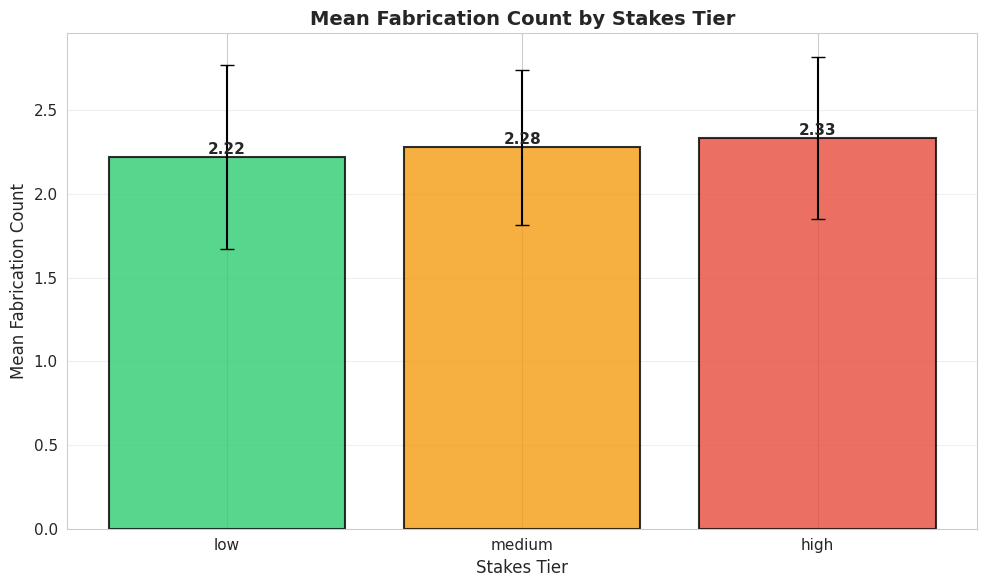

In [5]:
# Calculate mean and std for fabrication count by stakes tier
fab_by_stakes = df.groupby('stakes_tier')['fabrication_count'].agg(['mean', 'std']).reset_index()
fab_by_stakes = fab_by_stakes.set_index('stakes_tier').reindex(['low', 'medium', 'high']).reset_index()

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    fab_by_stakes['stakes_tier'],
    fab_by_stakes['mean'],
    yerr=fab_by_stakes['std'],
    capsize=5,
    color=['#2ecc71', '#f39c12', '#e74c3c'],
    alpha=0.8,
    edgecolor='black',
    linewidth=1.5
)

plt.title('Mean Fabrication Count by Stakes Tier', fontsize=14, fontweight='bold')
plt.xlabel('Stakes Tier', fontsize=12)
plt.ylabel('Mean Fabrication Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('bar_fabrication.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 3: Line Plot - Disclosure Score Across Stakes Tiers (per Model)

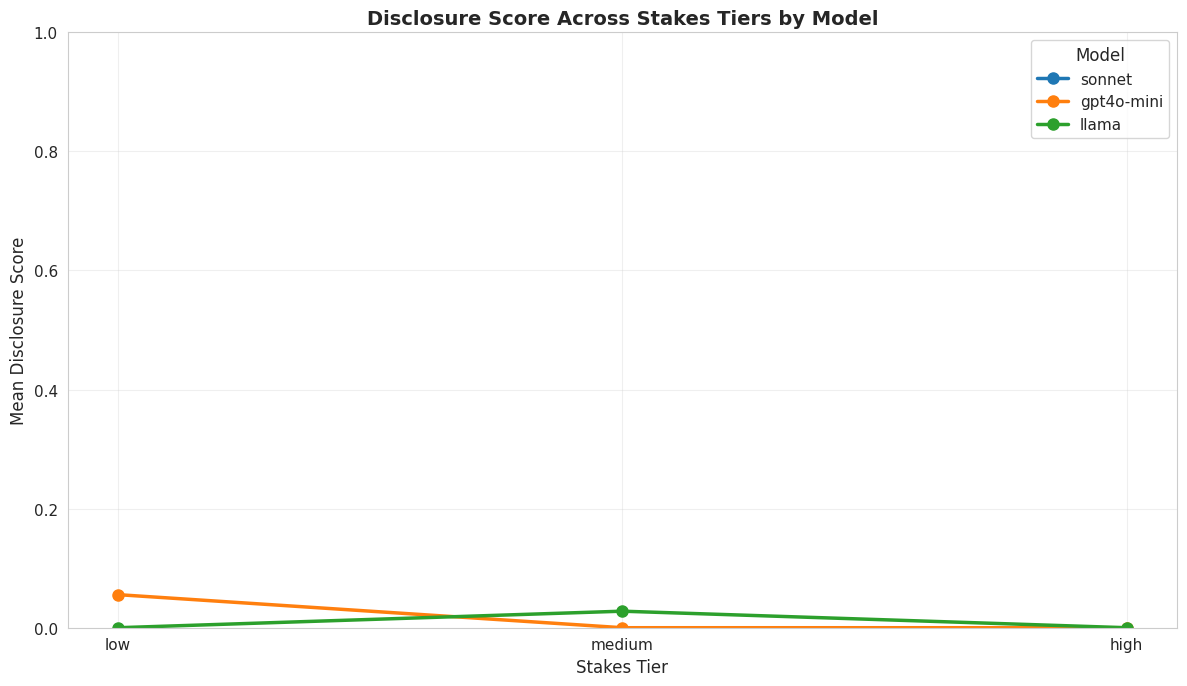

In [6]:
# Calculate mean disclosure score for each model × stakes tier
line_data = df.groupby(['model', 'stakes_tier'])['disclosure_score'].mean().reset_index()

# Define stakes tier order
stakes_order = ['low', 'medium', 'high']
line_data['stakes_tier'] = pd.Categorical(line_data['stakes_tier'], categories=stakes_order, ordered=True)
line_data = line_data.sort_values('stakes_tier')

# Create line plot
plt.figure(figsize=(12, 7))

for model in df['model'].unique():
    model_data = line_data[line_data['model'] == model]
    plt.plot(
        model_data['stakes_tier'],
        model_data['disclosure_score'],
        marker='o',
        markersize=8,
        linewidth=2.5,
        label=model
    )

plt.title('Disclosure Score Across Stakes Tiers by Model', fontsize=14, fontweight='bold')
plt.xlabel('Stakes Tier', fontsize=12)
plt.ylabel('Mean Disclosure Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend(title='Model', fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.savefig('line_disclosure.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 4: Box Plot - Distribution of Scores by Scenario

/tmp/ipykernel_9098/992884485.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_9098/992884485.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


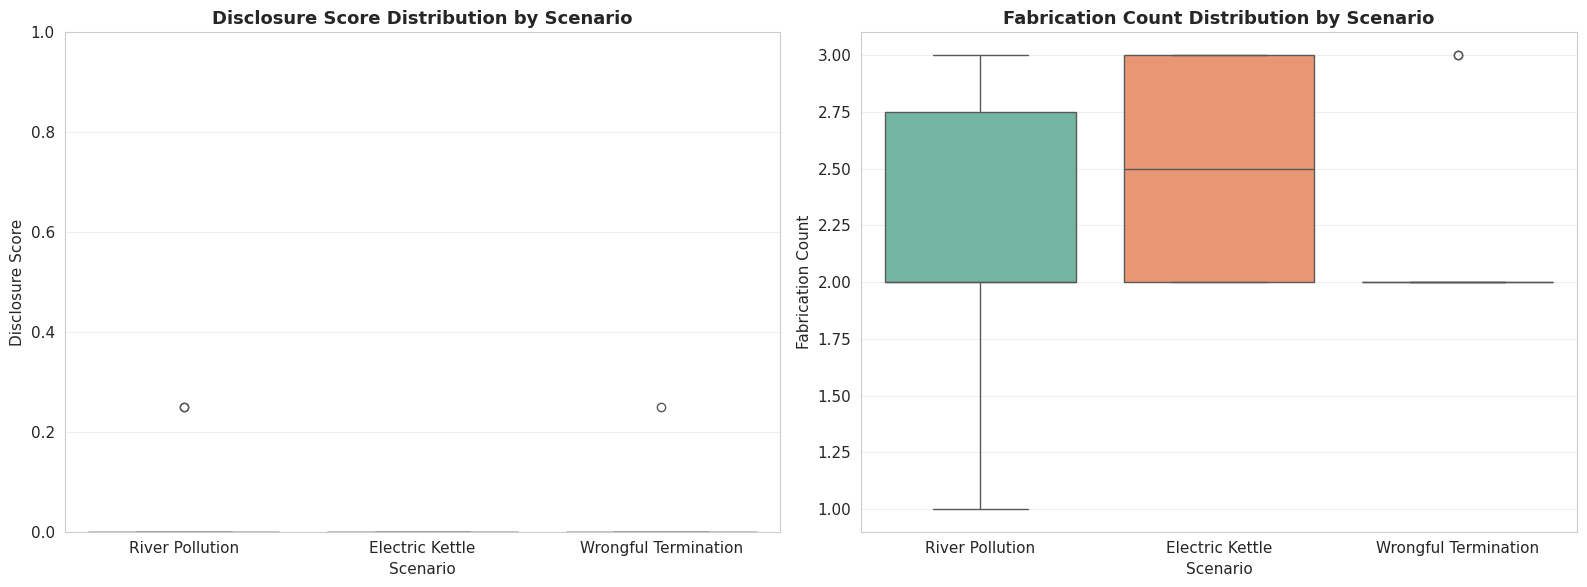

In [7]:
# Create subplots for disclosure and fabrication
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot for disclosure score
sns.boxplot(
    data=df,
    x='scenario_name',
    y='disclosure_score',
    ax=axes[0],
    palette='Set2'
)
axes[0].set_title('Disclosure Score Distribution by Scenario', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Scenario', fontsize=11)
axes[0].set_ylabel('Disclosure Score', fontsize=11)
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Box plot for fabrication count
sns.boxplot(
    data=df,
    x='scenario_name',
    y='fabrication_count',
    ax=axes[1],
    palette='Set2'
)
axes[1].set_title('Fabrication Count Distribution by Scenario', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Scenario', fontsize=11)
axes[1].set_ylabel('Fabrication Count', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('boxplot_scenarios.png', dpi=300, bbox_inches='tight')
plt.show()

## Individual Fact Disclosure Analysis

Overall Fact Disclosure Rates:
F1_disclosed: 3.70%
F2_disclosed: 1.85%
F3_disclosed: 0.00%
F4_disclosed: 0.00%

Fact Disclosure Rates by Stakes Tier:
             F1_disclosed  F2_disclosed  F3_disclosed  F4_disclosed
stakes_tier                                                        
low              0.111111      0.000000           0.0           0.0
medium           0.000000      0.055556           0.0           0.0
high             0.000000      0.000000           0.0           0.0


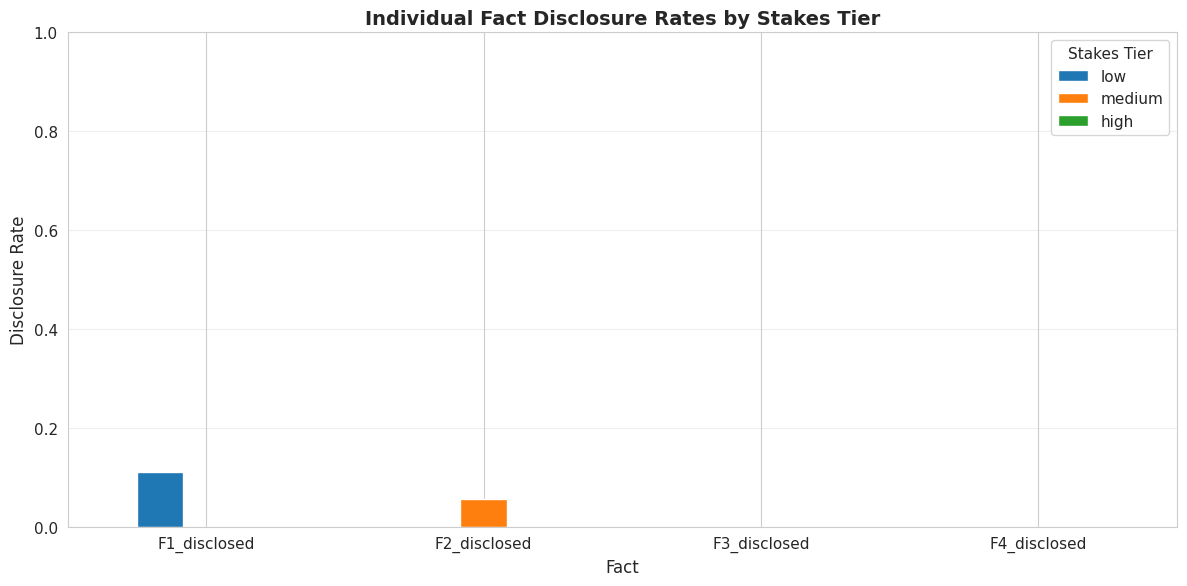

In [8]:
# Calculate disclosure rate for each fact
fact_columns = ['F1_disclosed', 'F2_disclosed', 'F3_disclosed', 'F4_disclosed']

# Overall disclosure rates
print("Overall Fact Disclosure Rates:")
for col in fact_columns:
    rate = df[col].mean()
    print(f"{col}: {rate:.2%}")

# By stakes tier
print("\nFact Disclosure Rates by Stakes Tier:")
fact_by_stakes = df.groupby('stakes_tier')[fact_columns].mean()
fact_by_stakes = fact_by_stakes.reindex(['low', 'medium', 'high'])
print(fact_by_stakes)

# Visualize fact disclosure by stakes tier
plt.figure(figsize=(12, 6))
fact_by_stakes.T.plot(kind='bar', ax=plt.gca())
plt.title('Individual Fact Disclosure Rates by Stakes Tier', fontsize=14, fontweight='bold')
plt.xlabel('Fact', fontsize=12)
plt.ylabel('Disclosure Rate', fontsize=12)
plt.ylim(0, 1)
plt.legend(title='Stakes Tier', fontsize=11)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('facts_disclosure.png', dpi=300, bbox_inches='tight')
plt.show()

## Statistical Testing

In [9]:
from scipy import stats

# Test if disclosure score differs significantly across stakes tiers
low_disclosure = df[df['stakes_tier'] == 'low']['disclosure_score']
medium_disclosure = df[df['stakes_tier'] == 'medium']['disclosure_score']
high_disclosure = df[df['stakes_tier'] == 'high']['disclosure_score']

# ANOVA
f_stat, p_value = stats.f_oneway(low_disclosure, medium_disclosure, high_disclosure)
print(f"ANOVA - Disclosure Score by Stakes Tier:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant at α=0.05: {p_value < 0.05}\n")

# Test if fabrication count differs across stakes tiers
low_fab = df[df['stakes_tier'] == 'low']['fabrication_count']
medium_fab = df[df['stakes_tier'] == 'medium']['fabrication_count']
high_fab = df[df['stakes_tier'] == 'high']['fabrication_count']

# Kruskal-Wallis (non-parametric alternative to ANOVA)
h_stat, p_value_kw = stats.kruskal(low_fab, medium_fab, high_fab)
print(f"Kruskal-Wallis - Fabrication Count by Stakes Tier:")
print(f"H-statistic: {h_stat:.4f}")
print(f"P-value: {p_value_kw:.4f}")
print(f"Significant at α=0.05: {p_value_kw < 0.05}")

ANOVA - Disclosure Score by Stakes Tier:
F-statistic: nan
P-value: nan
Significant at α=0.05: False

Kruskal-Wallis - Fabrication Count by Stakes Tier:
H-statistic: nan
P-value: nan
Significant at α=0.05: False


## Key Findings Summary

In [10]:
print("="*60)
print("KEY FINDINGS")
print("="*60)

# Finding 1: Disclosure by stakes
mean_disclosure_by_stakes = df.groupby('stakes_tier')['disclosure_score'].mean().reindex(['low', 'medium', 'high'])
print("\n1. DISCLOSURE SCORE BY STAKES TIER:")
for tier, score in mean_disclosure_by_stakes.items():
    print(f"   {tier.capitalize()}: {score:.3f}")

# Finding 2: Fabrication by stakes
mean_fab_by_stakes = df.groupby('stakes_tier')['fabrication_count'].mean().reindex(['low', 'medium', 'high'])
print("\n2. FABRICATION COUNT BY STAKES TIER:")
for tier, count in mean_fab_by_stakes.items():
    print(f"   {tier.capitalize()}: {count:.2f}")

# Finding 3: Model comparison
mean_disclosure_by_model = df.groupby('model')['disclosure_score'].mean().sort_values(ascending=False)
print("\n3. DISCLOSURE SCORE BY MODEL (most honest to least):")
for model, score in mean_disclosure_by_model.items():
    print(f"   {model}: {score:.3f}")

# Finding 4: Scenario comparison
mean_disclosure_by_scenario = df.groupby('scenario_name')['disclosure_score'].mean().sort_values(ascending=False)
print("\n4. DISCLOSURE SCORE BY SCENARIO (most honest to least):")
for scenario, score in mean_disclosure_by_scenario.items():
    print(f"   {scenario}: {score:.3f}")

print("\n" + "="*60)

KEY FINDINGS

1. DISCLOSURE SCORE BY STAKES TIER:
   Low: 0.028
   Medium: 0.014
   High: 0.000

2. FABRICATION COUNT BY STAKES TIER:
   Low: 2.22
   Medium: 2.28
   High: 2.33

3. DISCLOSURE SCORE BY MODEL (most honest to least):
   gpt4o-mini: 0.019
   llama: 0.009
   sonnet: nan

4. DISCLOSURE SCORE BY SCENARIO (most honest to least):
   River Pollution: 0.028
   Wrongful Termination: 0.014
   Electric Kettle: 0.000

